In [1]:
import pandas as pd 
import numpy as np 
import torch 
import wandb
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt  
from torch import nn 
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from torchvision import datasets, transforms
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall, MatthewsCorrCoef, F1Score, CohenKappa
import torchvision 
from tqdm import tqdm  
import torch.nn.functional as F
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from torchvision import models
from pytorch_lightning import Trainer
import pytorch_lightning.metrics.functional as metrics 
from help_funcs import *

C:\Users\USER\anaconda3\envs\provectus\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: artyom9090. Use `wandb login --relogin` to force relogin


True

At the moment of development arose problem with PyTorch lighting integration with Wandb. Logs during training hadn't saved. By the reason of narrow time I decided to use wand directly 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
root = r'C:\Users\USER\Desktop\New_task\flowers-recognition\flowers'
size = 224 #NOTE: Change size of image dependant from model. Efficientnet can obtain 224*224 while Inception 256*256

# Download dataset and  prepare dataset 

Lets use already defined helper functions

In [5]:
#od.download('https://www.kaggle.com/datasets/alxmamaev/flowers-recognition')
#splitfolders.ratio("../Task/flowers-recognition/flowers", output="flowers_",
#    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)
root = r'C:\Users\USER\Desktop\New_task\flowers-recognition\flowers'
size = 224

In [6]:
flower_dataset = read_dataset(root, 224)
flower_dataset.class_to_idx
idx2class = {v: k for k, v in flower_dataset.class_to_idx.items()}

In [7]:
train_loader, valid_loader = train_test_split_with_stratification(flower_dataset)

In [8]:
len(train_loader), len(valid_loader)

(54, 14)

For using _class_distribution_loaders func. please, 
change batch_size to 1 in train_test_split_stratification func. in helper_funcs

In [9]:
#get_class_distribution_loaders(train_loader, flower_dataset)

As we can see ratios of classes in original dataset and train/test sets are the same 

# Vizualization of samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([4, 4, 1, 2, 2, 2])


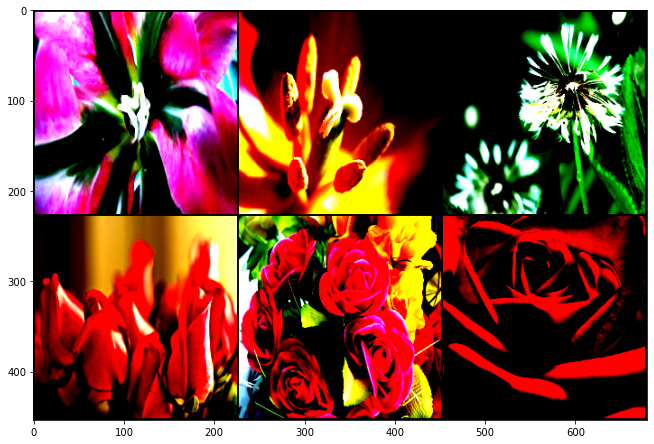

In [10]:
train_batch, label_train = next(iter(train_loader))
valid_batch, label_val = next(iter(valid_loader))

def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('labels: ', labels)

show_transformed_images(flower_dataset)

# Configuration of training for wandb sync. 

In [12]:
config = dict(
    epochs=20,
    classes=5,
    batch_size=64,
    learning_rate=0.005,
    dataset="Flower recognition",
    architecture="NN")


# Model selection (transfer learning)

Inception v3, with approximately 23.8 mln parameters, is an image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. 
The model is the culmination of many ideas developed by multiple researchers over the years. 
The model itself is made up of symmetric and asymmetric building blocks, including convolutions, 
average pooling, max pooling, concatenations, dropouts, and fully connected layers. 
Batch normalization is used extensively throughout the model and applied to activation inputs. 
Loss is computed using Softmax. It is enough big net pretrained on the ImageNet can be used for transfer learning.
Because of the lack of recources and time I decided not train the whole network but fine tune only last layer

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of 
depth/width/resolution using a compound coefficient. Unlike conventional practice that arbitrary scales these factors, 
the EfficientNet scaling method uniformly scales network width, depth, and resolution with a set of fixed scaling coefficients. 
It has only 7.8 mln parameters and showed 79.2% Top 1 accuracy on ImageNet. It is comparably small but efficient model which used in image recognition cases. As in the case with Inception I will fine tune only the last layer og the network and in the end show comparison of performance metrics of this thow models

The dataset unsignificantly imbalance, howerer for understanding efficiency I decided to use as the main metrics
Matthews correlation coefficient and Cohen Kappa which used in multiclass classification problems with imbalanced dataset.
As well as during training process used standart classification metrtics such as accuracy, precision, recall and F1

As optimizer I used ADAM and Cross Entropy as loss.

Training will be conducted for 20 epochs 

In [13]:
class Model(pl.LightningModule):

    def __init__(self, lr= config['learning_rate'], numclasses= config['classes'], modelname = 'inception', config = config):
        super(Model, self).__init__()
        self.config = config
        wandb.init(project="Fig", config=self.config)
        self.save_hyperparameters()
        self.lr = lr
        self.numclasses = numclasses
        self.modelname = modelname
        self.create_model()
        self.accuracy = Accuracy(num_classes = self.numclasses) 
        self.precision = Precision(num_classes = self.numclasses)
        self.recall = Recall(num_classes = self.numclasses)
        self.f1 = F1Score(num_classes = self.numclasses)
        self.matthews = MatthewsCorrCoef(num_classes = self.numclasses)
        self.cohen_kappa = CohenKappa(num_classes = self.numclasses)
        
    def create_model(self):
        if self.modelname == 'inception':
            self.model = torchvision.models.inception_v3(pretrained=True, aux_logits=False)
            for param in self.model.parameters():
                param.requires_grad = False
            self.model.fc = nn.Linear(in_features=2048, out_features= self.numclasses, bias=True)
        elif self.modelname == 'efficientnet':    
            self.model = torchvision.models.efficientnet_b1(pretrained=True, aux_logits=False)
            for param in self.model.parameters():
                param.requires_grad = False

            self.model.classifier[1] = nn.Linear(in_features=1280, out_features= self.numclasses, bias=True)
        else:
            raise ValueError('Please, choose inception or efficientnet')
    
    
    def forward(self, x):
        output = self.model(x)
        return output

    def training_step(self, batch, batch_idx):
        images, target = batch
        preds = self.forward(images)
        loss = F.cross_entropy(preds, target)
        accuracy = self.accuracy(preds, target)
        precision = self.precision(preds, target)
        recall = self.recall(preds, target)
        f1 = self.f1(preds, target)
        matthews = self.matthews(preds, target)
        cohen_kappa = self.cohen_kappa(preds, target)
        #logs = {'train_loss': loss, 'Accuracy': accuracy}
        #self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        wandb.log({'Train loss' : loss, 'Train accuracy' : accuracy,
                  'Precision' : precision, 'Recall' : recall,
                  'F1' : f1, 'Matthews' : matthews,
                 'Cohen kappa' : cohen_kappa
                  })
        return {'loss' : loss}
    
    def validation_step(self, batch, batch_idx):
        images_val, target_val = batch
        preds_val = self.forward(images_val)
        val_loss = F.cross_entropy(preds_val, target_val)
        val_acc = self.accuracy(preds_val, target_val)
        wandb.log({'Validation loss' : val_loss,
                  'Validation accuracy' : val_acc
                  })
        return {'val_loss' : val_loss}
    
    
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
        return [optimizer], [scheduler]

In [14]:
model = Model(modelname = 'efficientnet', config = config)
model

Model(
  (model): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation): 

In [15]:
trainer_1 = Trainer(gpus = 1, max_epochs = config['epochs'])
trainer_1.fit(model, train_loader, valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
C:\Users\USER\anaconda3\envs\provectus\lib\site-packages\pytorch_lightning\utilities\distributed.py:25: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | EfficientNet     | 6 M   
1 | accuracy    | Accuracy         | 0     
2 | precision   | Precision        | 0     
3 | recall      | Recall           | 0     
4 | f1          | F1Score          | 0     
5 | matthews    | MatthewsCorrCoef | 0     
6 | cohen_kappa | CohenKappa       | 0     


Epoch 1:  76%|███████▋  | 52/68 [00:17<00:05,  2.92it/s, loss=0.427, v_num=46]


C:\Users\USER\anaconda3\envs\provectus\lib\site-packages\pytorch_lightning\utilities\distributed.py:25: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1